### Nested Time Series

In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(tsibble))
suppressMessages(library(fable))
suppressMessages(library(tsibble))
suppressMessages(library(fabletools))
suppressMessages(library(feasts))
suppressMessages(library(lubridate))
suppressMessages(library(scales))
suppressMessages(library(fpp3))
suppressMessages(library(gridExtra))

plot_prefix <- 'plots/w11_'

Warning message:
"package 'ggplot2' was built under R version 4.3.2"


In [2]:
tourism <- tsibble::tourism |>
  mutate(State = recode(State,
    `New South Wales` = "NSW",
    `Northern Territory` = "NT",
    `Queensland` = "QLD",
    `South Australia` = "SA",
    `Tasmania` = "TAS",
    `Victoria` = "VIC",
    `Western Australia` = "WA"
  ))

tourism_hts <- tourism |>
aggregate_key(State / Region, Trips = sum(Trips))

tourism_hts %>% head()

Quarter,State,Region,Trips
<qtr>,<chr*>,<chr*>,<dbl>
1998 Q1,<aggregated>,<aggregated>,23182.20
1998 Q2,<aggregated>,<aggregated>,20323.38
1998 Q3,<aggregated>,<aggregated>,19826.64
1998 Q4,<aggregated>,<aggregated>,20830.13
1999 Q1,<aggregated>,<aggregated>,22087.35
1999 Q2,<aggregated>,<aggregated>,21458.37


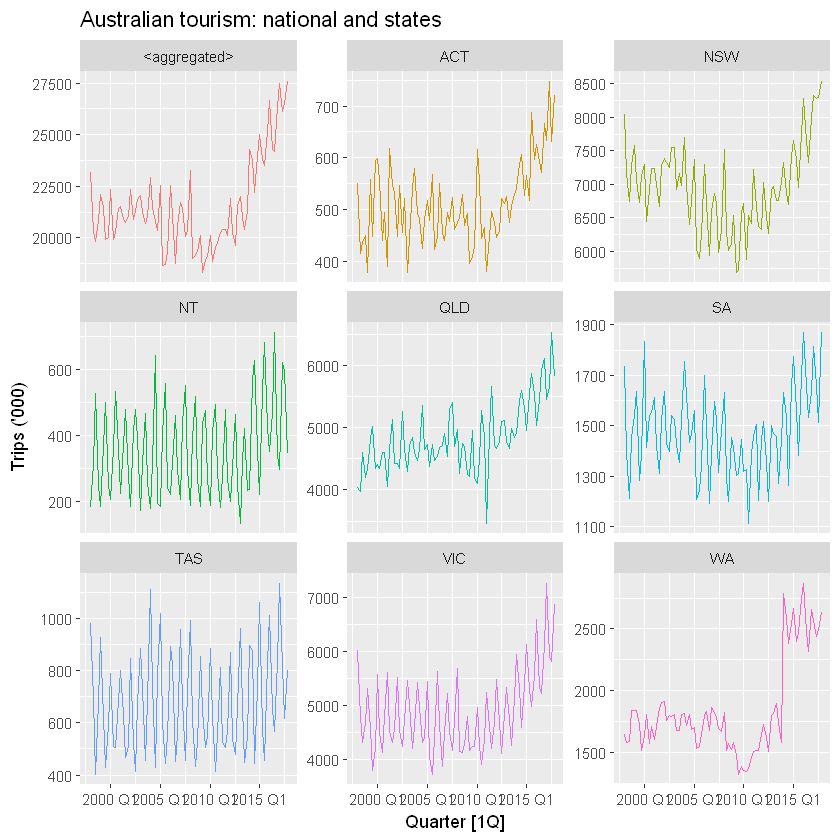

In [3]:
tourism_hts |>
  filter(is_aggregated(Region)) |>
  autoplot(Trips) +
  labs(y = "Trips ('000)",
       title = "Australian tourism: national and states") +
  facet_wrap(vars(State), scales = "free_y", ncol = 3) +
  theme(legend.position = "none")

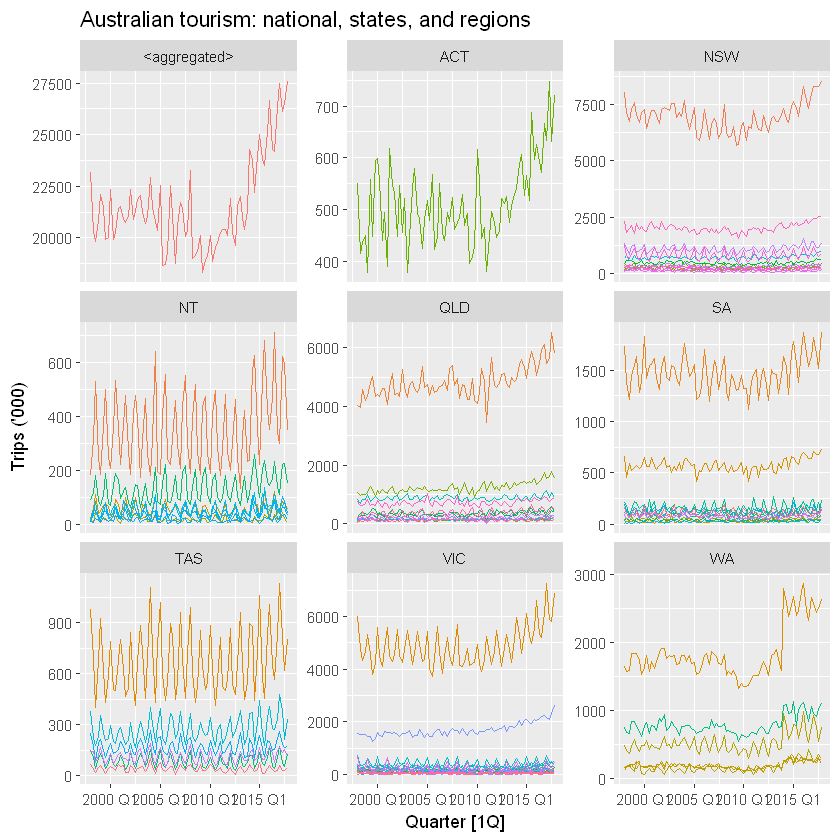

In [4]:
tourism_hts |>
  autoplot(Trips) +
  labs(y = "Trips ('000)",
       title = "Australian tourism: national, states, and regions") +
  facet_wrap(vars(State), scales = "free_y", ncol = 3) +
  theme(legend.position = "none")

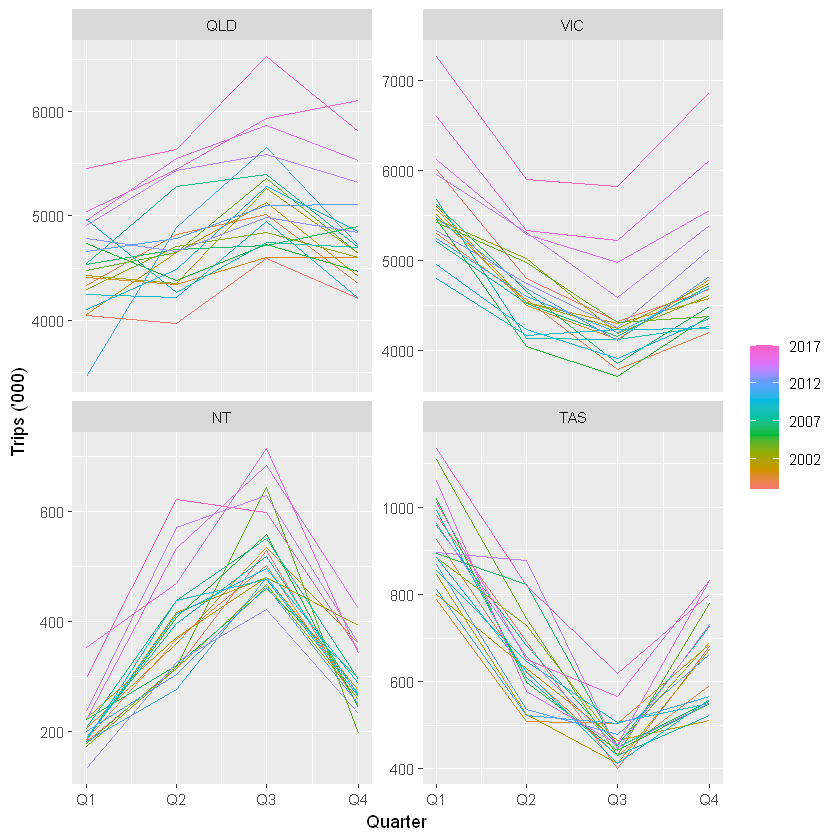

In [5]:
tourism_hts |>
  filter(State == "NT" | State == "QLD" |
         State == "TAS" | State == "VIC", is_aggregated(Region)) |>
  select(-Region) |>
  mutate(State = factor(State, levels=c("QLD","VIC","NT","TAS"))) |>
  gg_season(Trips) +
  facet_wrap(vars(State), nrow = 2, scales = "free_y")+
  labs(y = "Trips ('000)")

### Grouped Data

In [6]:
prison <- readr::read_csv("https://OTexts.com/fpp3/extrafiles/prison_population.csv") |>
  mutate(Quarter = yearquarter(Date)) |>
  select(-Date)  |>
  as_tsibble(key = c(Gender, Legal, State, Indigenous),
             index = Quarter) |>
  relocate(Quarter)

Rows: 3072 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): State, Gender, Legal, Indigenous
dbl  (1): Count
date (1): Date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
prison %>% head()

Quarter,State,Gender,Legal,Indigenous,Count
<qtr>,<chr>,<chr>,<chr>,<chr>,<dbl>
2005 Q1,ACT,Female,Remanded,ATSI,0
2005 Q2,ACT,Female,Remanded,ATSI,1
2005 Q3,ACT,Female,Remanded,ATSI,0
2005 Q4,ACT,Female,Remanded,ATSI,0
2006 Q1,ACT,Female,Remanded,ATSI,1
2006 Q2,ACT,Female,Remanded,ATSI,1


In [8]:
prisoners_gts <- prison %>%
    aggregate_key(Gender * Legal * State, Count = sum(Count)/1e3)

In [9]:
prisoners_gts %>% head()

Quarter,Gender,Legal,State,Count
<qtr>,<chr*>,<chr*>,<chr*>,<dbl>
2005 Q1,<aggregated>,<aggregated>,<aggregated>,24.296
2005 Q2,<aggregated>,<aggregated>,<aggregated>,24.643
2005 Q3,<aggregated>,<aggregated>,<aggregated>,24.511
2005 Q4,<aggregated>,<aggregated>,<aggregated>,24.393
2006 Q1,<aggregated>,<aggregated>,<aggregated>,24.524
2006 Q2,<aggregated>,<aggregated>,<aggregated>,25.017


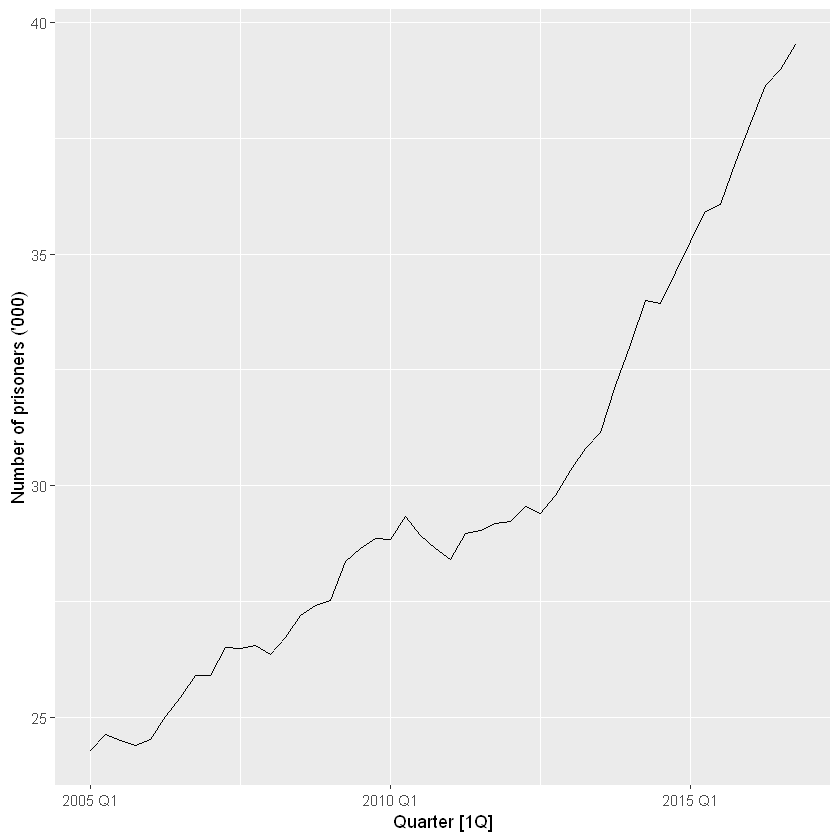

In [10]:
prisoners_gts |>
  filter(is_aggregated(Gender), is_aggregated(Legal),
         is_aggregated(State)) |>
  autoplot(Count) +
  labs(y = "Number of prisoners ('000)")

ggsave(paste(plot_prefix, 'prisoners_agg.png', sep=''), height = 3, width = 6)

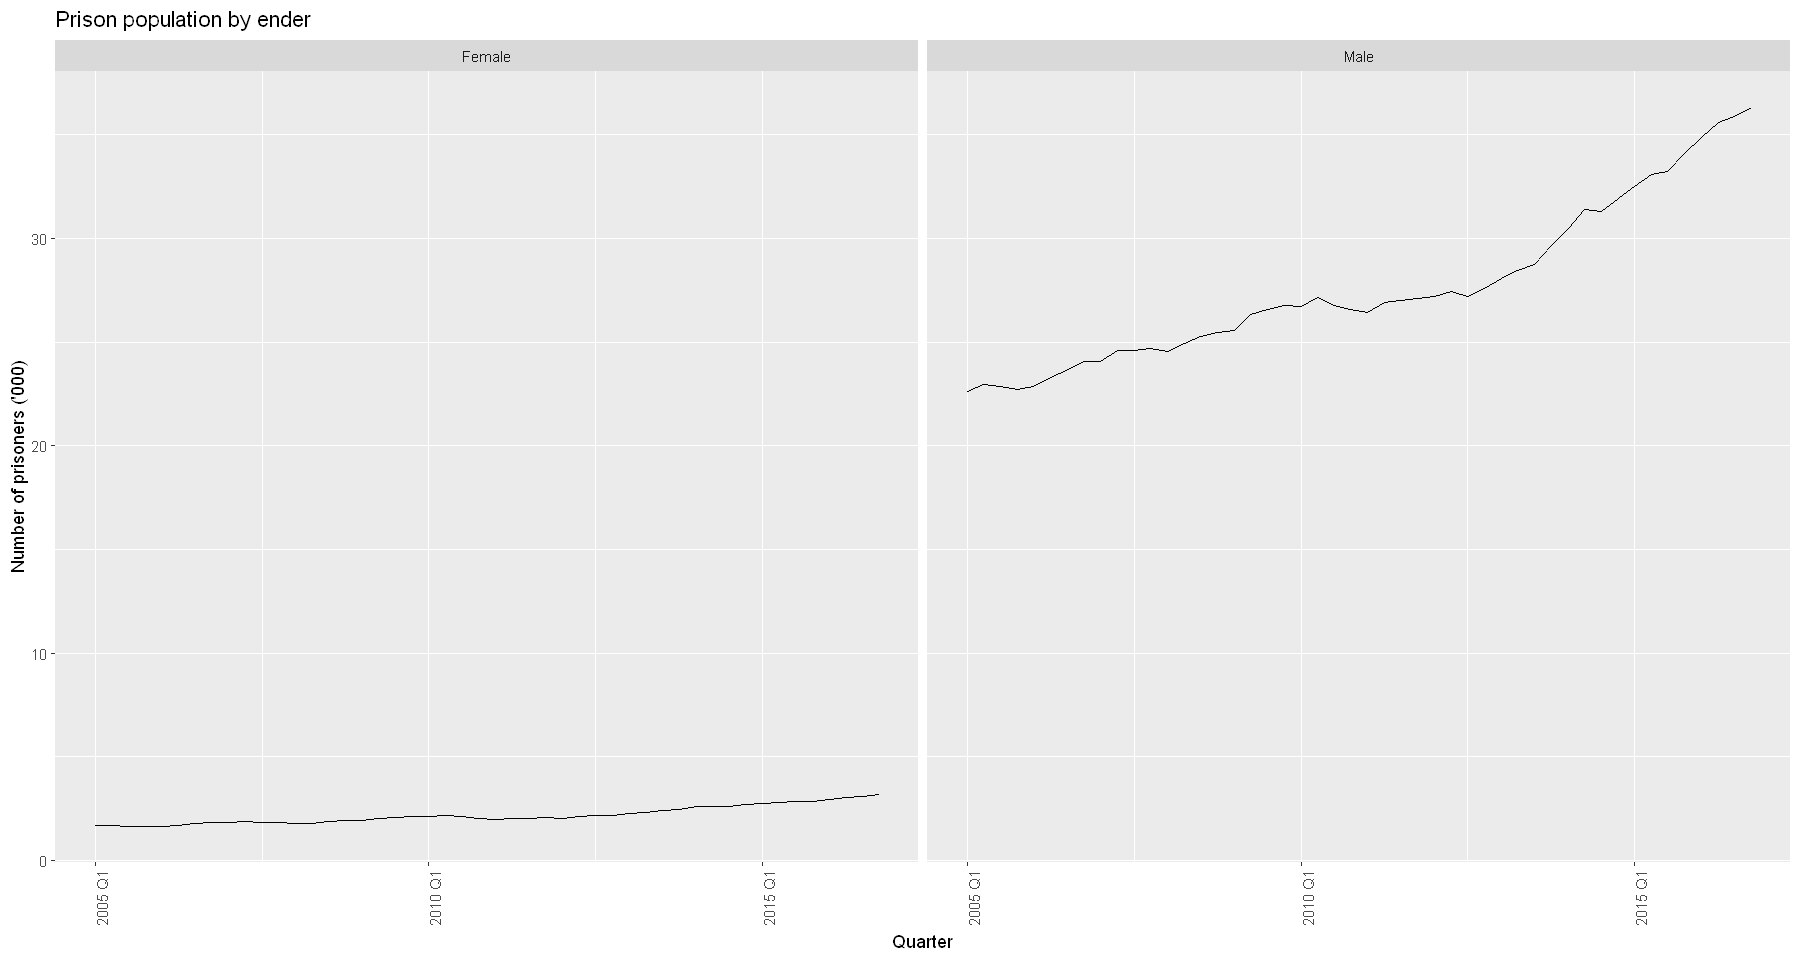

In [11]:
options(repr.plot.width=15, repr.plot.height=8)

prisoners_gts |>
  filter(!is_aggregated(Gender), is_aggregated(Legal),
         is_aggregated(State)) |>
  mutate(Gender = as.character(Gender)) |>
  ggplot(aes(x = Quarter, y = Count)) +
  stat_summary(fun = sum, geom = "line") +
  labs(title = "Prison population by ender",
       y = "Number of prisoners ('000)") +
  facet_wrap(~ as.character(Gender), nrow = 1) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

ggsave(paste(plot_prefix, 'prisoner_by_gender.png', sep=''), height = 3, width = 6)

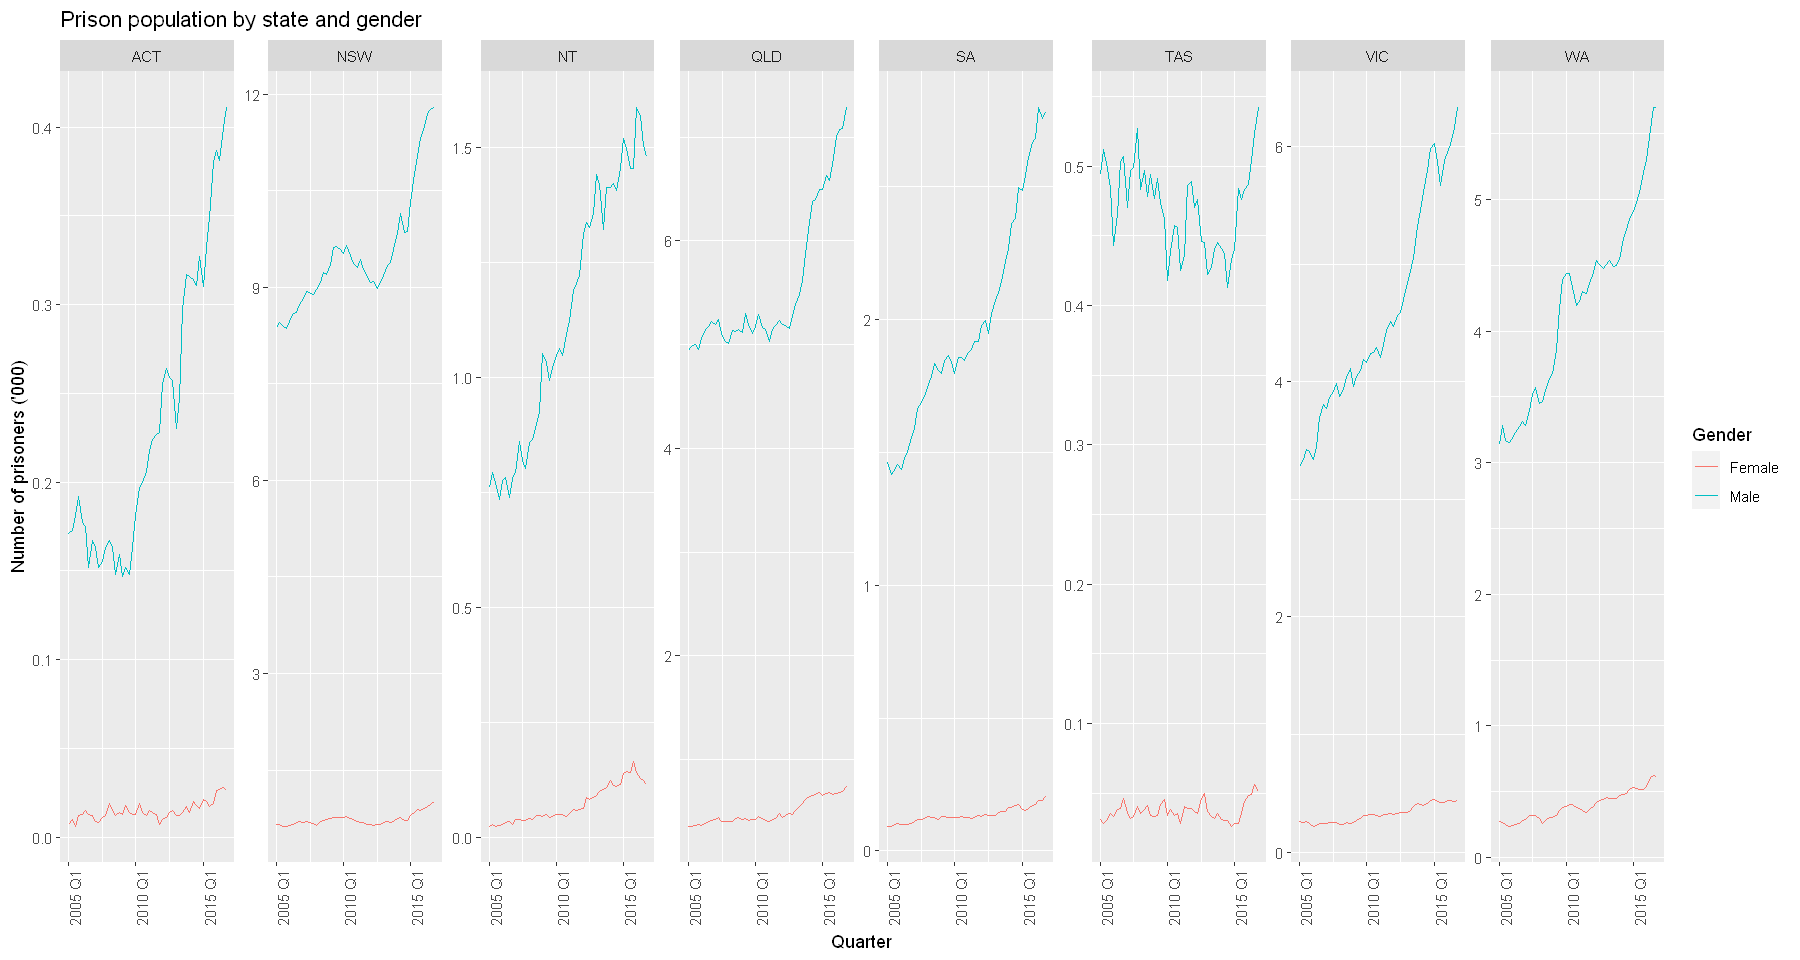

In [12]:
options(repr.plot.width=15, repr.plot.height=8)

prisoners_gts |>
  filter(!is_aggregated(Gender), !is_aggregated(Legal),
         !is_aggregated(State)) |>
  mutate(Gender = as.character(Gender)) |>
  ggplot(aes(x = Quarter, y = Count,
             group = Gender, colour=Gender)) +
  stat_summary(fun = sum, geom = "line") +
  labs(title = "Prison population by state and gender",
       y = "Number of prisoners ('000)") +
  facet_wrap(~ as.character(State),
             nrow = 1, scales = "free_y") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

  ggsave(paste(plot_prefix, 'prisoner_by_gender_and_state.png', sep=''), height = 3, width = 10)

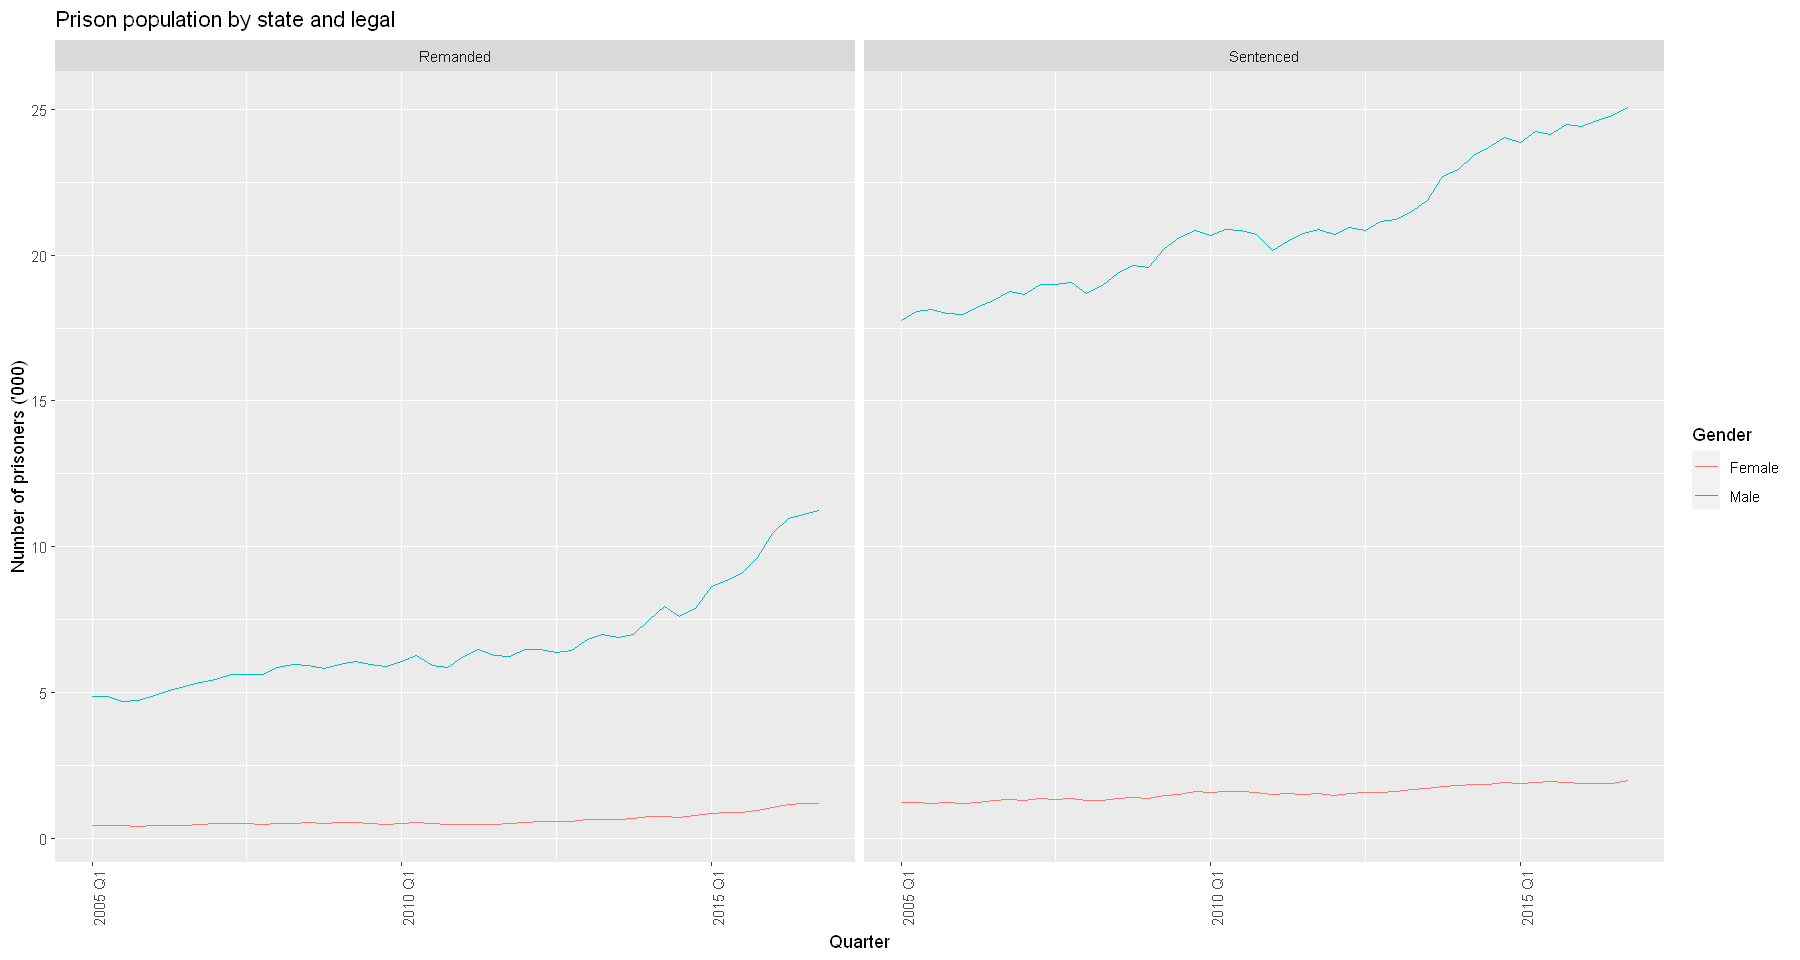

In [13]:
options(repr.plot.width=15, repr.plot.height=8)

prisoners_gts |>
  filter(!is_aggregated(Gender), !is_aggregated(Legal),
         is_aggregated(State)) |>
  mutate(Gender = as.character(Gender)) |>
  ggplot(aes(x = Quarter, y = Count,
             group = Gender, colour=Gender)) +
  stat_summary(fun = sum, geom = "line") +
  labs(title = "Prison population by state and legal",
       y = "Number of prisoners ('000)") +
  facet_wrap(~ as.character(Legal), nrow = 1) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

ggsave(paste(plot_prefix, 'prisoner_by_gender_and_legal.png', sep=''), height = 3, width = 6)

### Crossed Data Example with Tourism

In [14]:
tourism_full <- tourism |>
  aggregate_key((State/Region) * Purpose, Trips = sum(Trips))

tourism_full %>% head()

Quarter,State,Purpose,Region,Trips
<qtr>,<chr*>,<chr*>,<chr*>,<dbl>
1998 Q1,<aggregated>,<aggregated>,<aggregated>,23182.20
1998 Q2,<aggregated>,<aggregated>,<aggregated>,20323.38
1998 Q3,<aggregated>,<aggregated>,<aggregated>,19826.64
1998 Q4,<aggregated>,<aggregated>,<aggregated>,20830.13
1999 Q1,<aggregated>,<aggregated>,<aggregated>,22087.35
1999 Q2,<aggregated>,<aggregated>,<aggregated>,21458.37


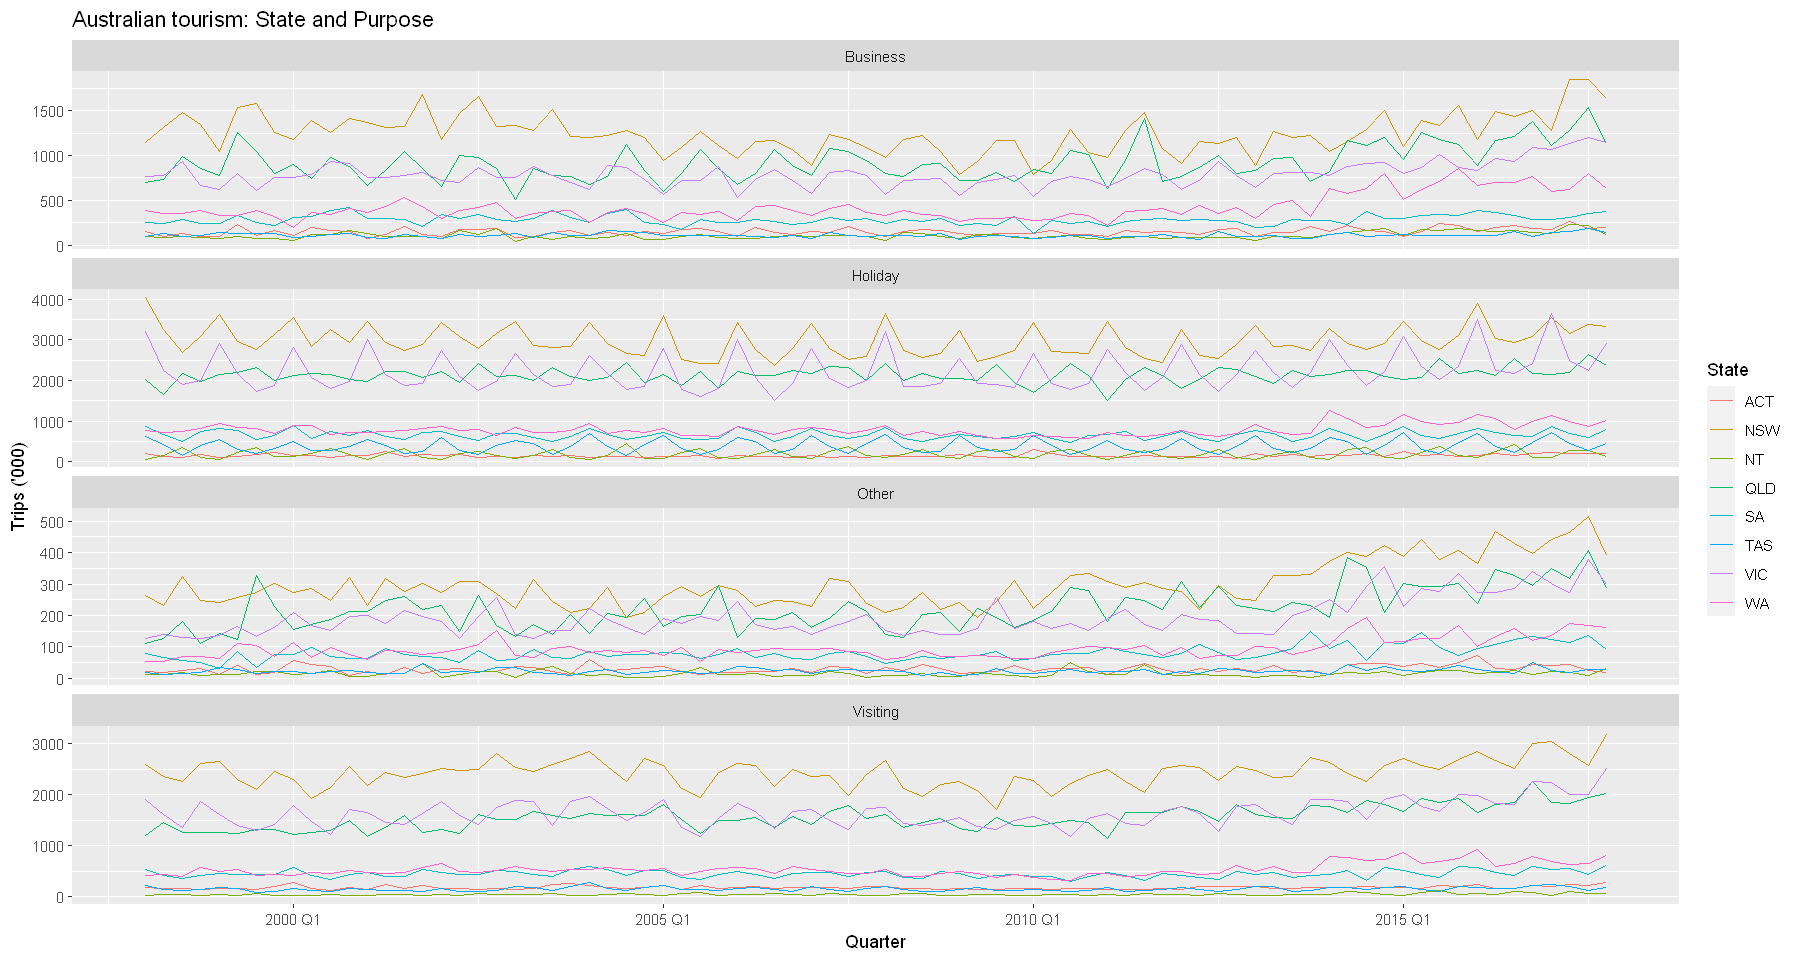

In [15]:
tourism_full |>
filter(!is_aggregated(State), is_aggregated(Region), !is_aggregated(Purpose)) |>
mutate(State = as.character(State)) |>
ggplot(aes(x=Quarter, y=Trips, group=State, colour=State)) +
stat_summary(fun = sum, geom = "line") +
facet_wrap(as.character(Purpose) ~ ., scales = "free_y", ncol = 1)  + 
labs(y = "Trips ('000)", title = "Australian tourism: State and Purpose")

ggsave(paste(plot_prefix, 'tourism_state_purpose.png', sep=''), height=7, width = 5)

### Bottom-ups Forecast for Tourism
State to National Forecasts

In [16]:
tourism_states <- tourism |>
  aggregate_key(State, Trips = sum(Trips))

tourism_states %>% head()

Quarter,State,Trips
<qtr>,<chr*>,<dbl>
1998 Q1,<aggregated>,23182.20
1998 Q2,<aggregated>,20323.38
1998 Q3,<aggregated>,19826.64
1998 Q4,<aggregated>,20830.13
1999 Q1,<aggregated>,22087.35
1999 Q2,<aggregated>,21458.37


In [17]:
tourism_states |> count(State)

State,n
<chr*>,<int>
ACT,80
NSW,80
NT,80
QLD,80
SA,80
TAS,80
VIC,80
WA,80
<aggregated>,80


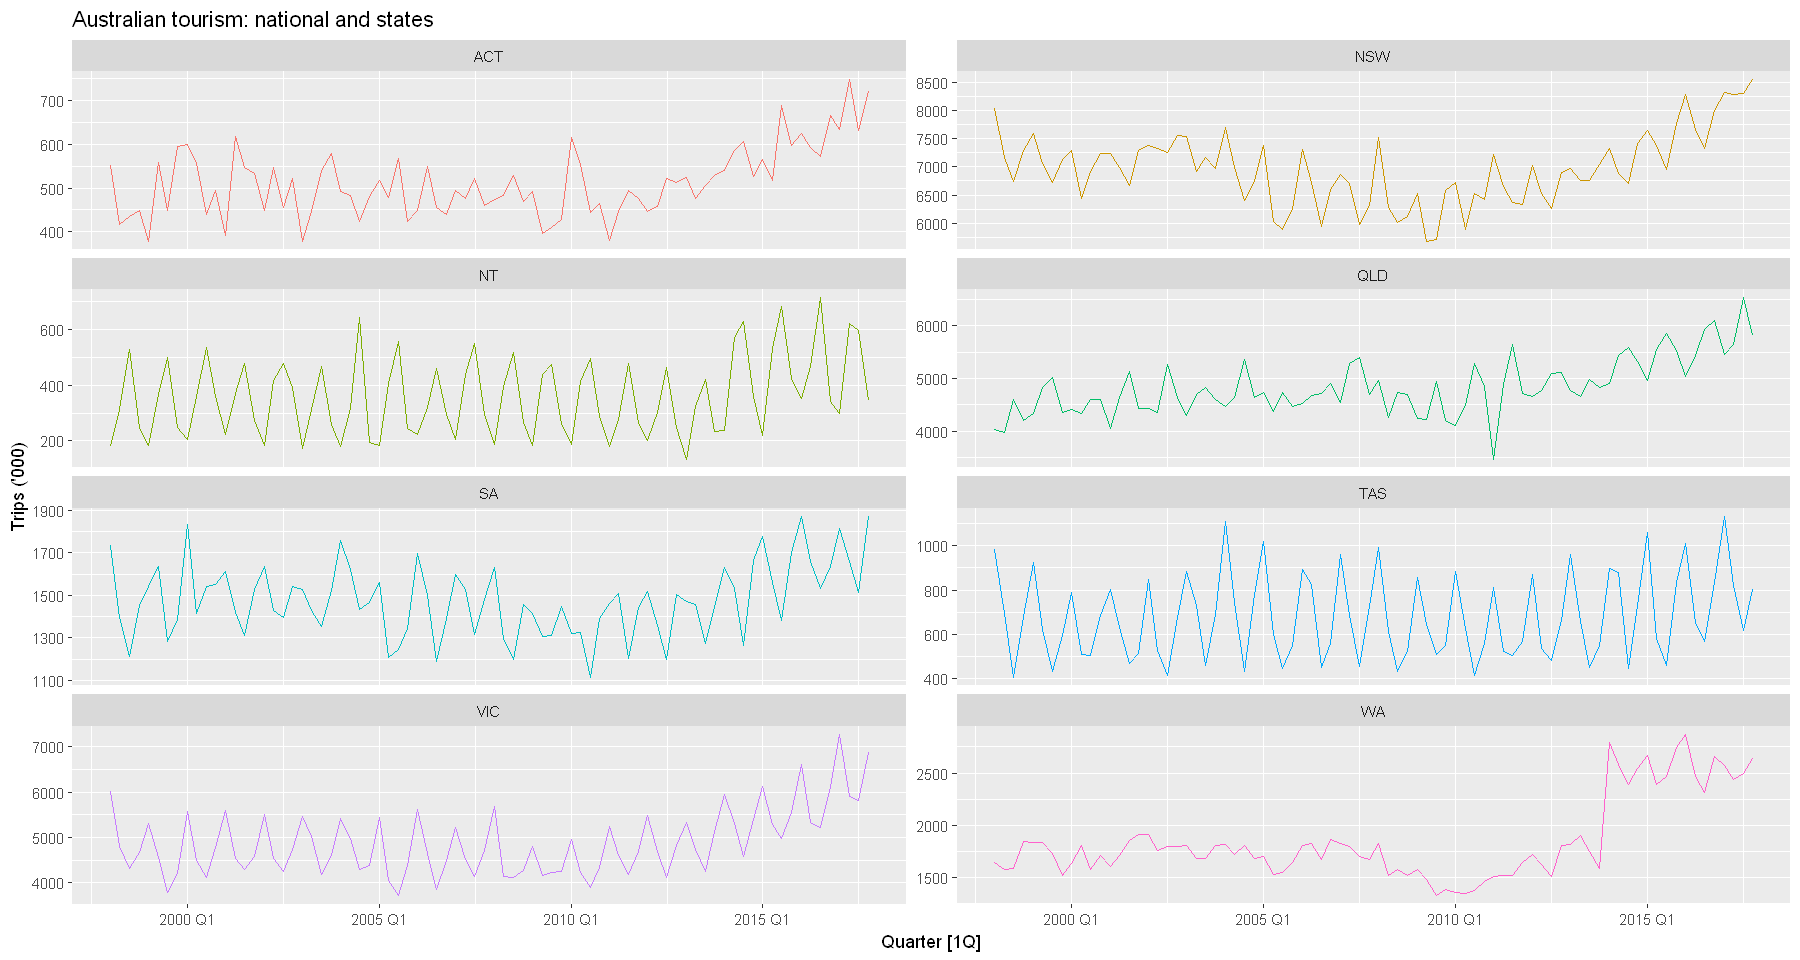

In [18]:
tourism_states |>
  filter(!is_aggregated(State)) |>
  autoplot(Trips) +
  labs(y = "Trips ('000)",
       title = "Australian tourism: national and states") +
  facet_wrap(vars(State), scales = "free_y", ncol = 2) +
  theme(legend.position = "none")

ggsave(paste(plot_prefix, 'tourism_state_facet.png', sep=''), height = 6, width = 5)

Could produce the forecasts and simply sum to get the aggregates:

In [19]:
fcasts_state <- tourism_states |>
  filter(!is_aggregated(State)) |>
  model(ets = ETS(Trips)) |>
  forecast()

# Sum bottom-level forecasts to get top-level forecasts
fcasts_national <- fcasts_state |>
  summarise(value = sum(Trips), .mean = mean(value))

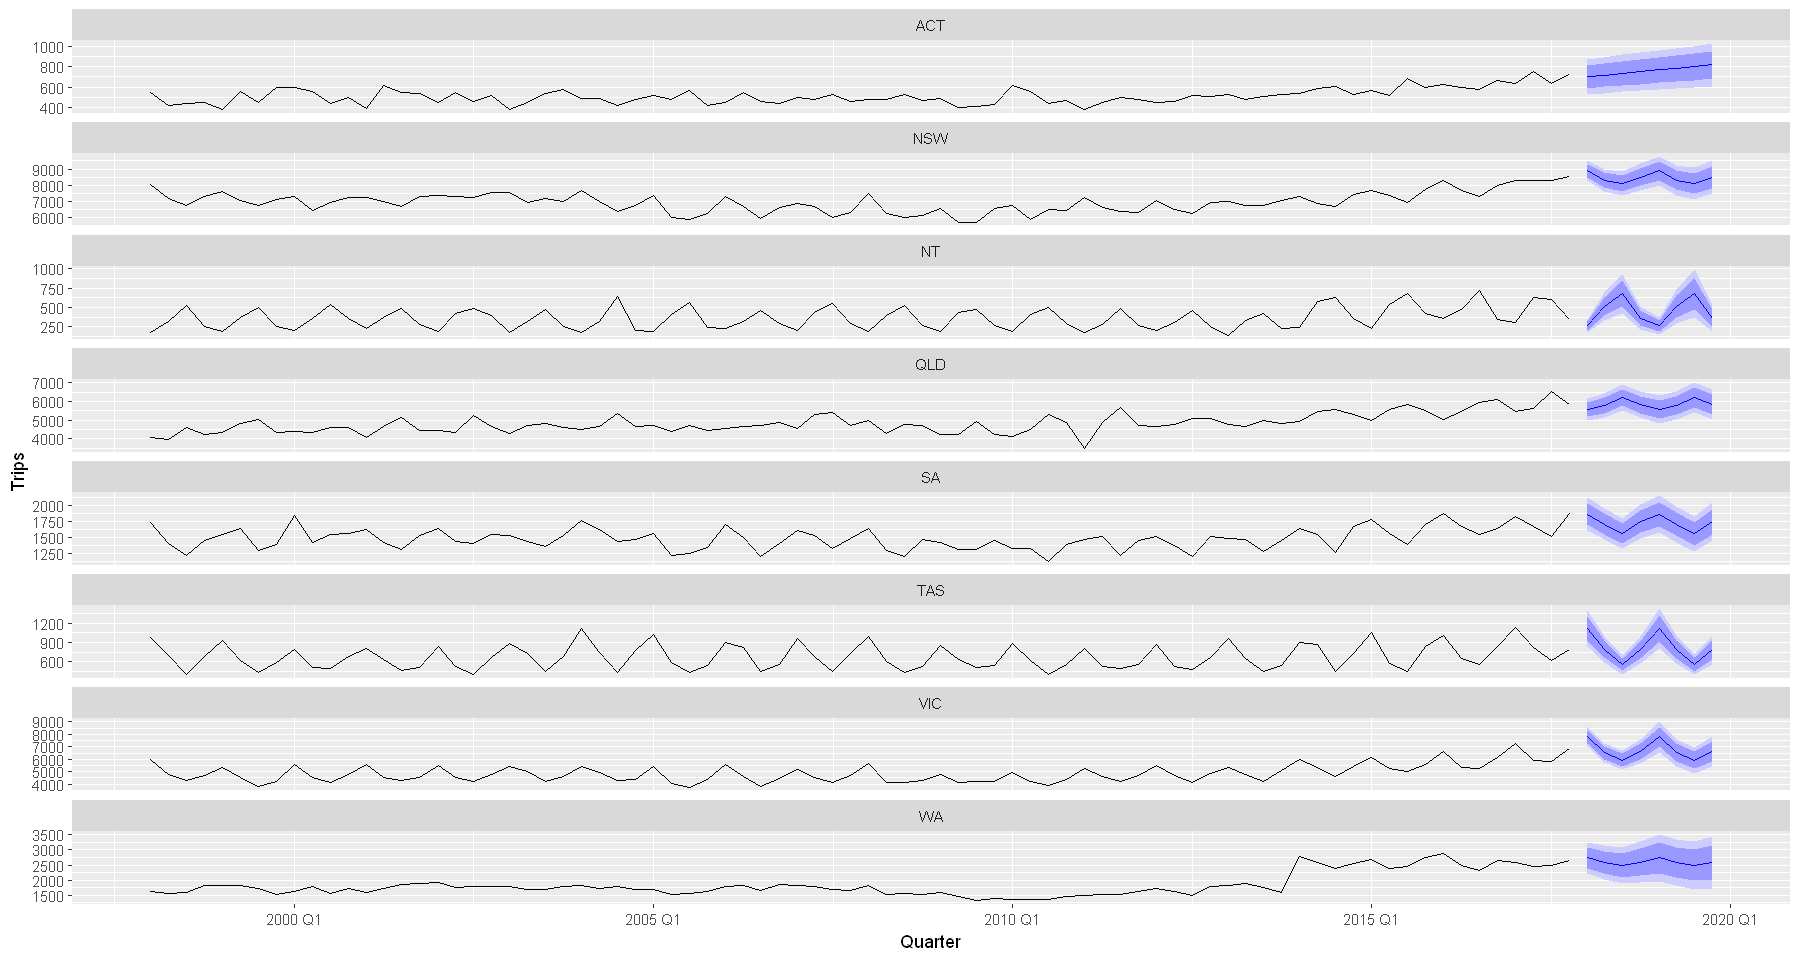

In [20]:
fcasts_state %>% autoplot(tourism_states)  +
  theme(legend.position = "none")

ggsave(paste(plot_prefix, 'tourism_state_forecasts.png',sep = ''), height = 6, width = 4)

Or use reconciliation which is going to be more generalized:

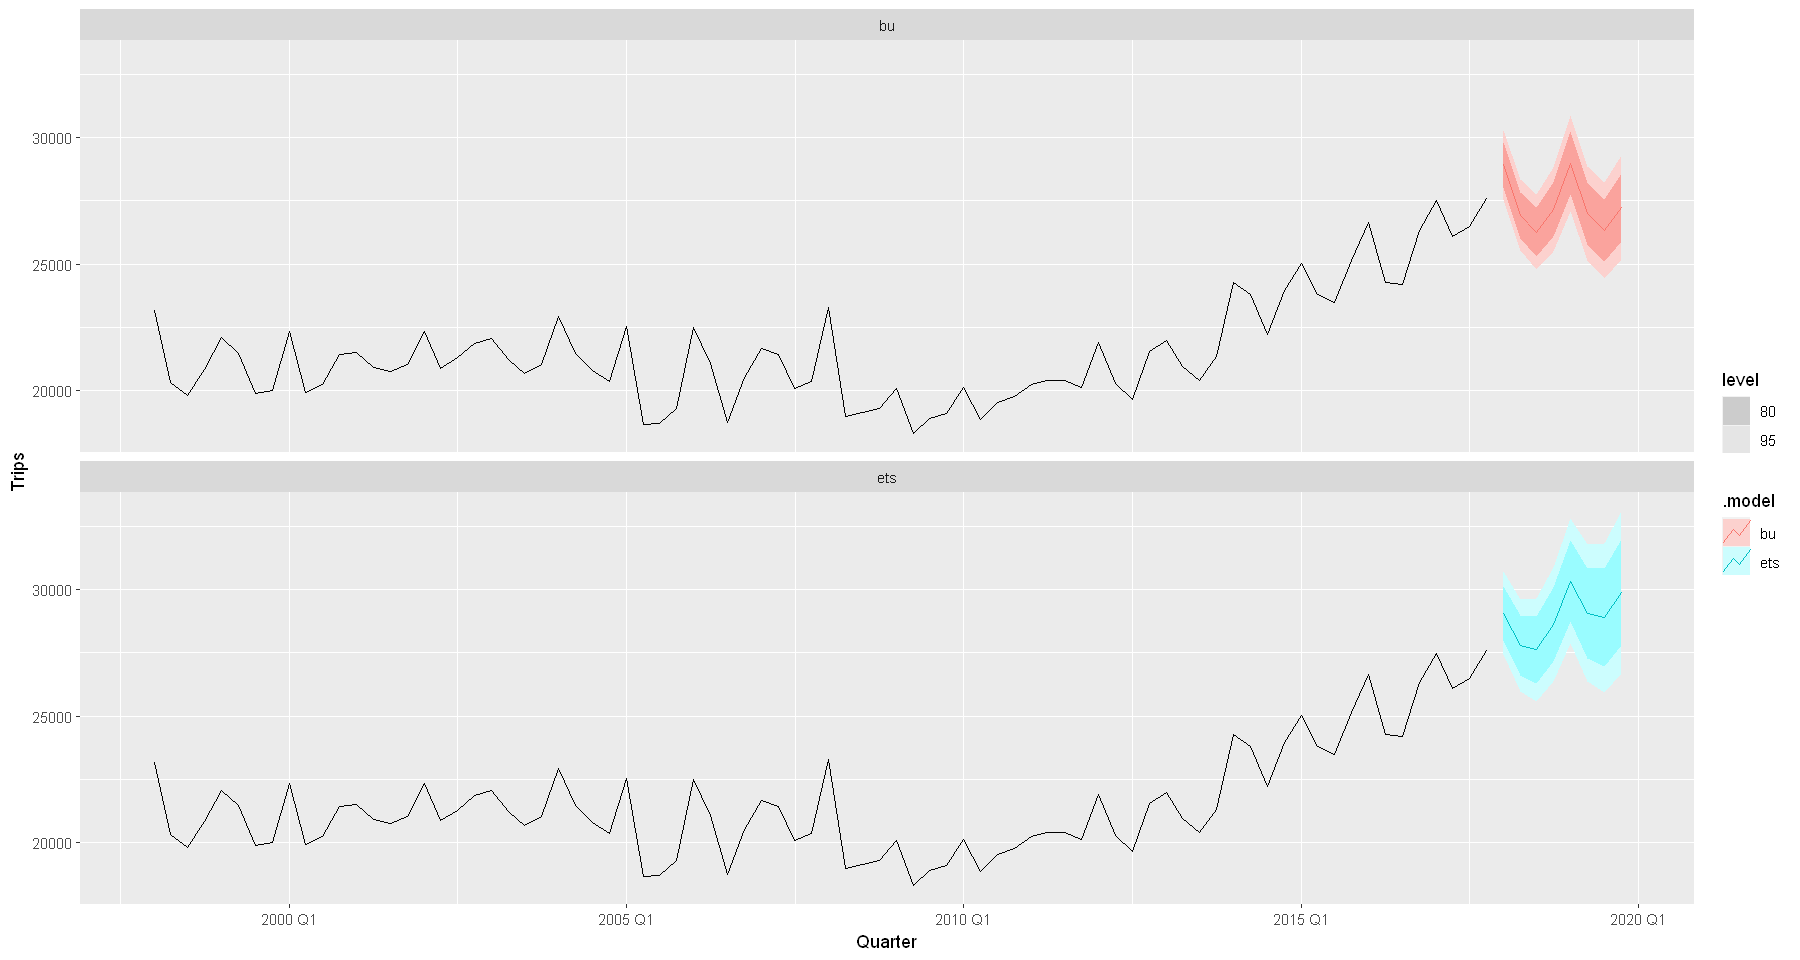

In [21]:
fcast_both <- tourism_states |>
  model(ets = ETS(Trips)) |>
  reconcile(bu = bottom_up(ets)) |>
  forecast()

fcast_both %>% filter(is_aggregated(State)) %>% autoplot(tourism_states) + facet_wrap(. ~ .model, ncol=1)

ggsave(paste(plot_prefix, 'tourism_state_bu_national_forecasts.png'), height = 6, width = 5)

### Comparing Top-down Methods

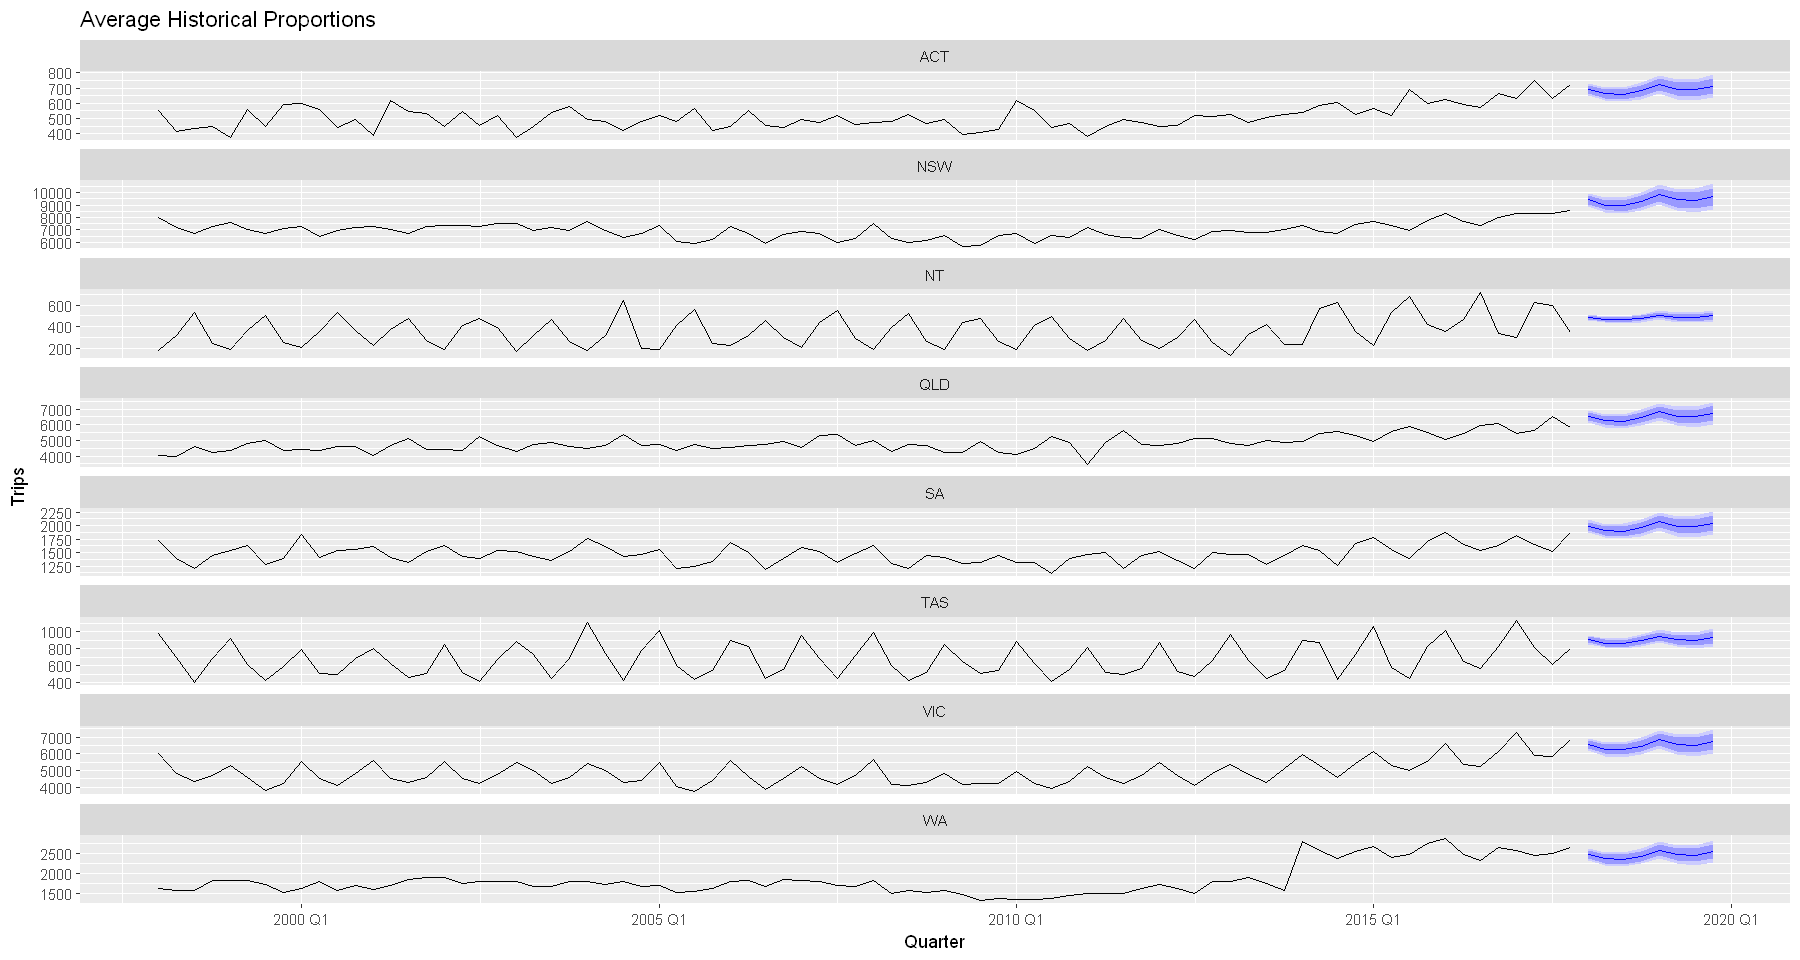

In [22]:
tourism_states |>
  model(ets = ETS(Trips)) |>
  reconcile(td = top_down(ets, method = 'average_proportions')) |>
  forecast() |>
  filter(!is_aggregated(State), .model == 'td') |>
  autoplot(tourism_states)  +
  theme(legend.position = "none") +
  labs(title='Average Historical Proportions')

ggsave(paste(plot_prefix, 'tourism_state_topdown_avg_proportion.png', sep=''), height = 6, width = 5)

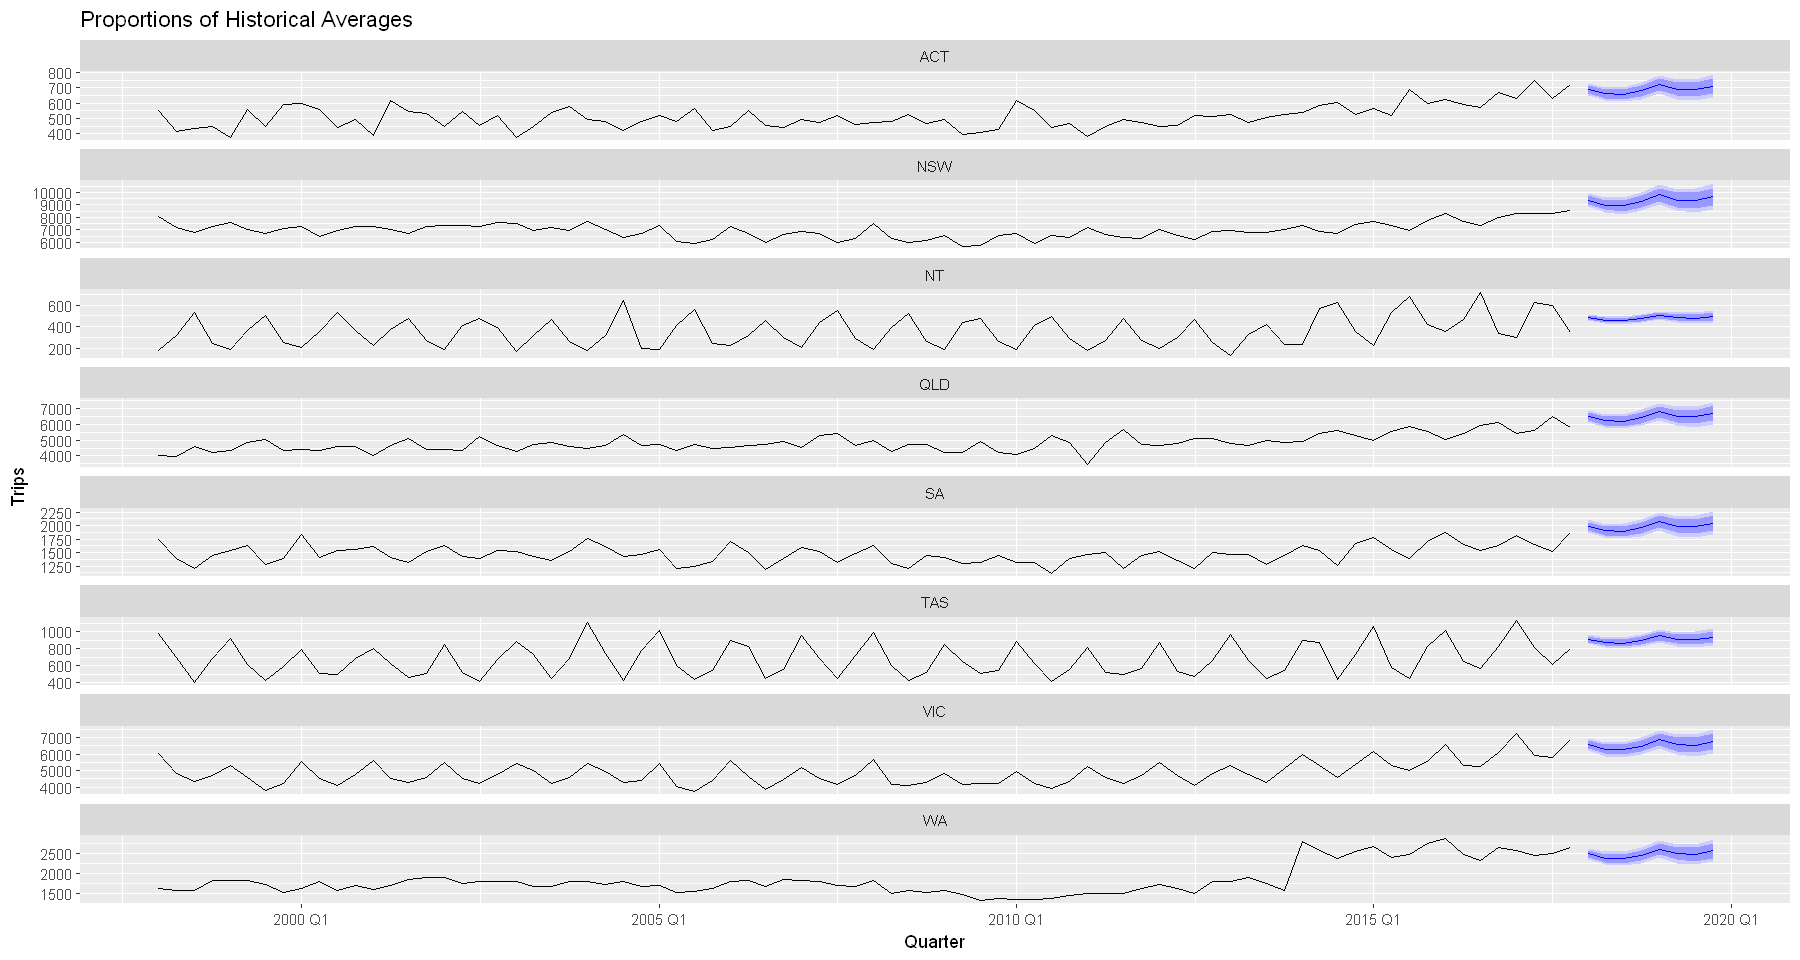

In [23]:
tourism_states |>
  model(ets = ETS(Trips)) |>
  reconcile(td = top_down(ets, method = 'proportion_averages')) |>
  forecast() |>
  filter(!is_aggregated(State), .model == 'td') |>
  autoplot(tourism_states)  +
  theme(legend.position = "none") +
  labs(title='Proportions of Historical Averages')

ggsave(paste(plot_prefix, 'tourism_state_topdown_avg_hist_proportion.png', sep=''), height = 6, width = 5)

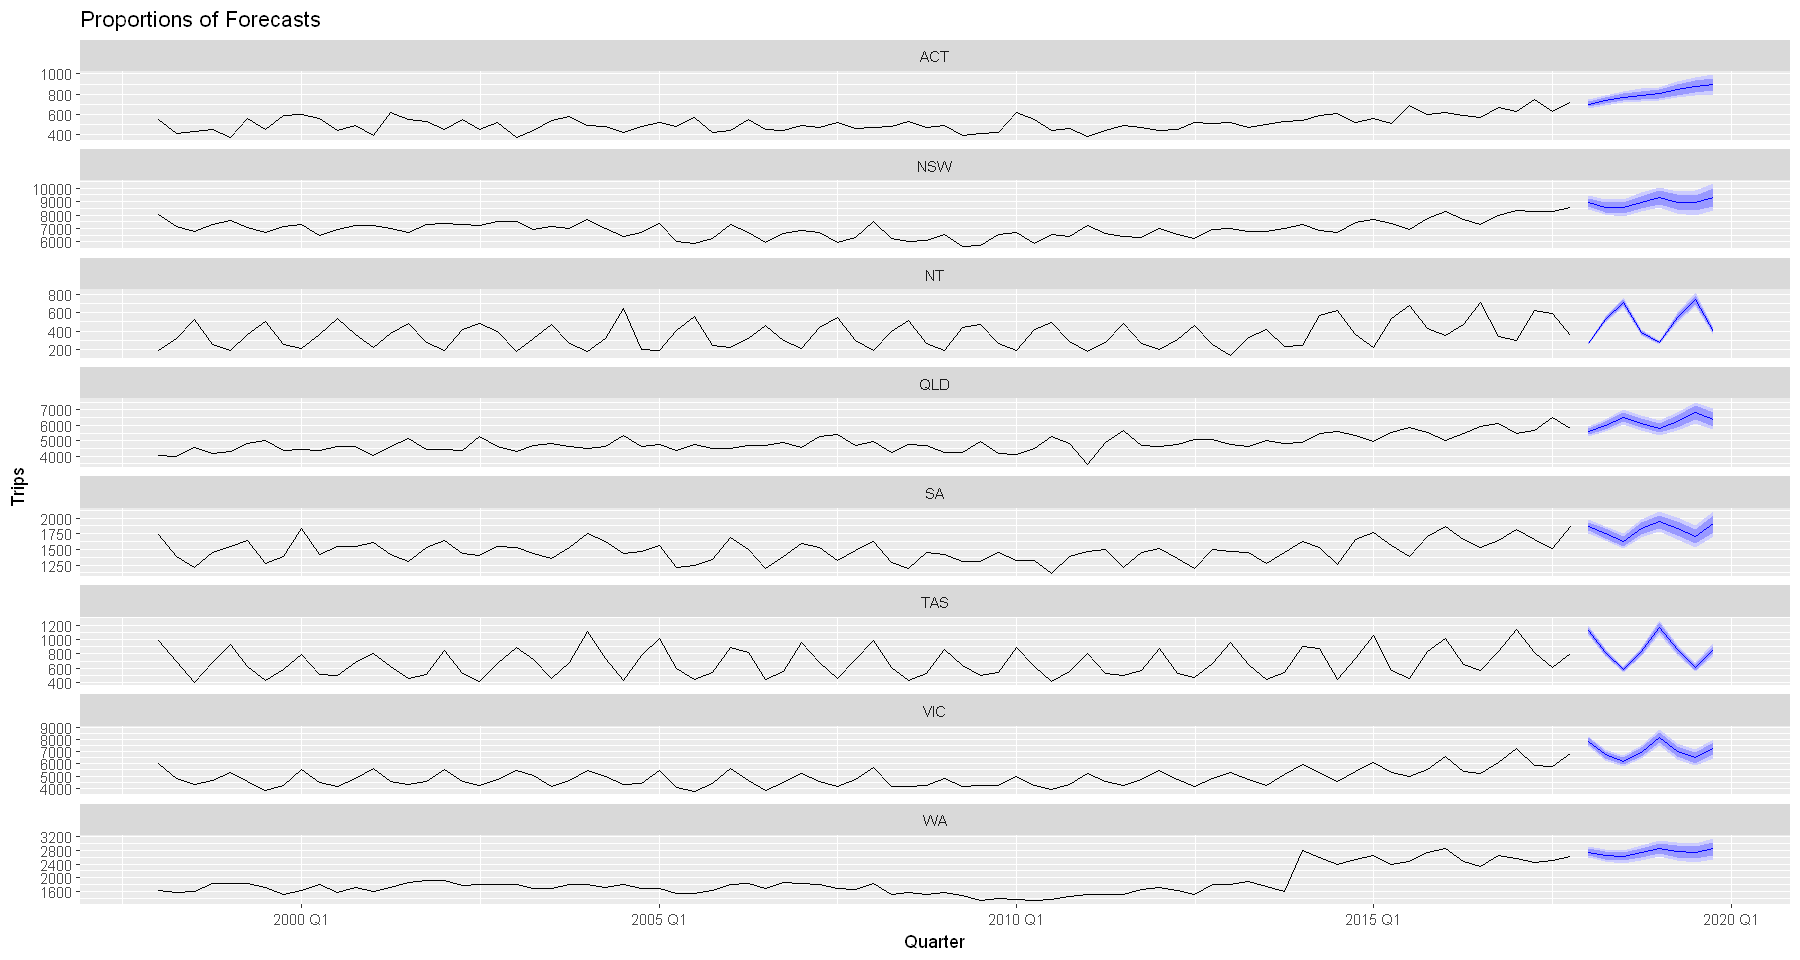

In [24]:
tourism_states |>
  model(ets = ETS(Trips)) |>
  reconcile(td = top_down(ets, method = 'forecast_proportions')) |>
  forecast() |>
  filter(!is_aggregated(State), .model == 'td') |>
  autoplot(tourism_states)  +
  theme(legend.position = "none") +
  labs(title='Proportions of Forecasts')

ggsave(paste(plot_prefix, 'tourism_state_topdown_forecast_proportion.png', sep=''), height = 6, width = 5)

### Comparing Reconciliations with Tourism Data
Now four level (Aggregate, State, Region, Purpose)

In [25]:
tourism_full <- tourism |>
  aggregate_key((State/Region) * Purpose, Trips = sum(Trips))

fit <- tourism_full |>
  filter(year(Quarter) <= 2015) |>
  model(base = ETS(Trips)) |>
  reconcile(
    bu = bottom_up(base),
    ols = min_trace(base, method = "ols"),
    mint = min_trace(base, method = "mint_shrink")
  )

fc <- fit |> forecast(h = "2 years")

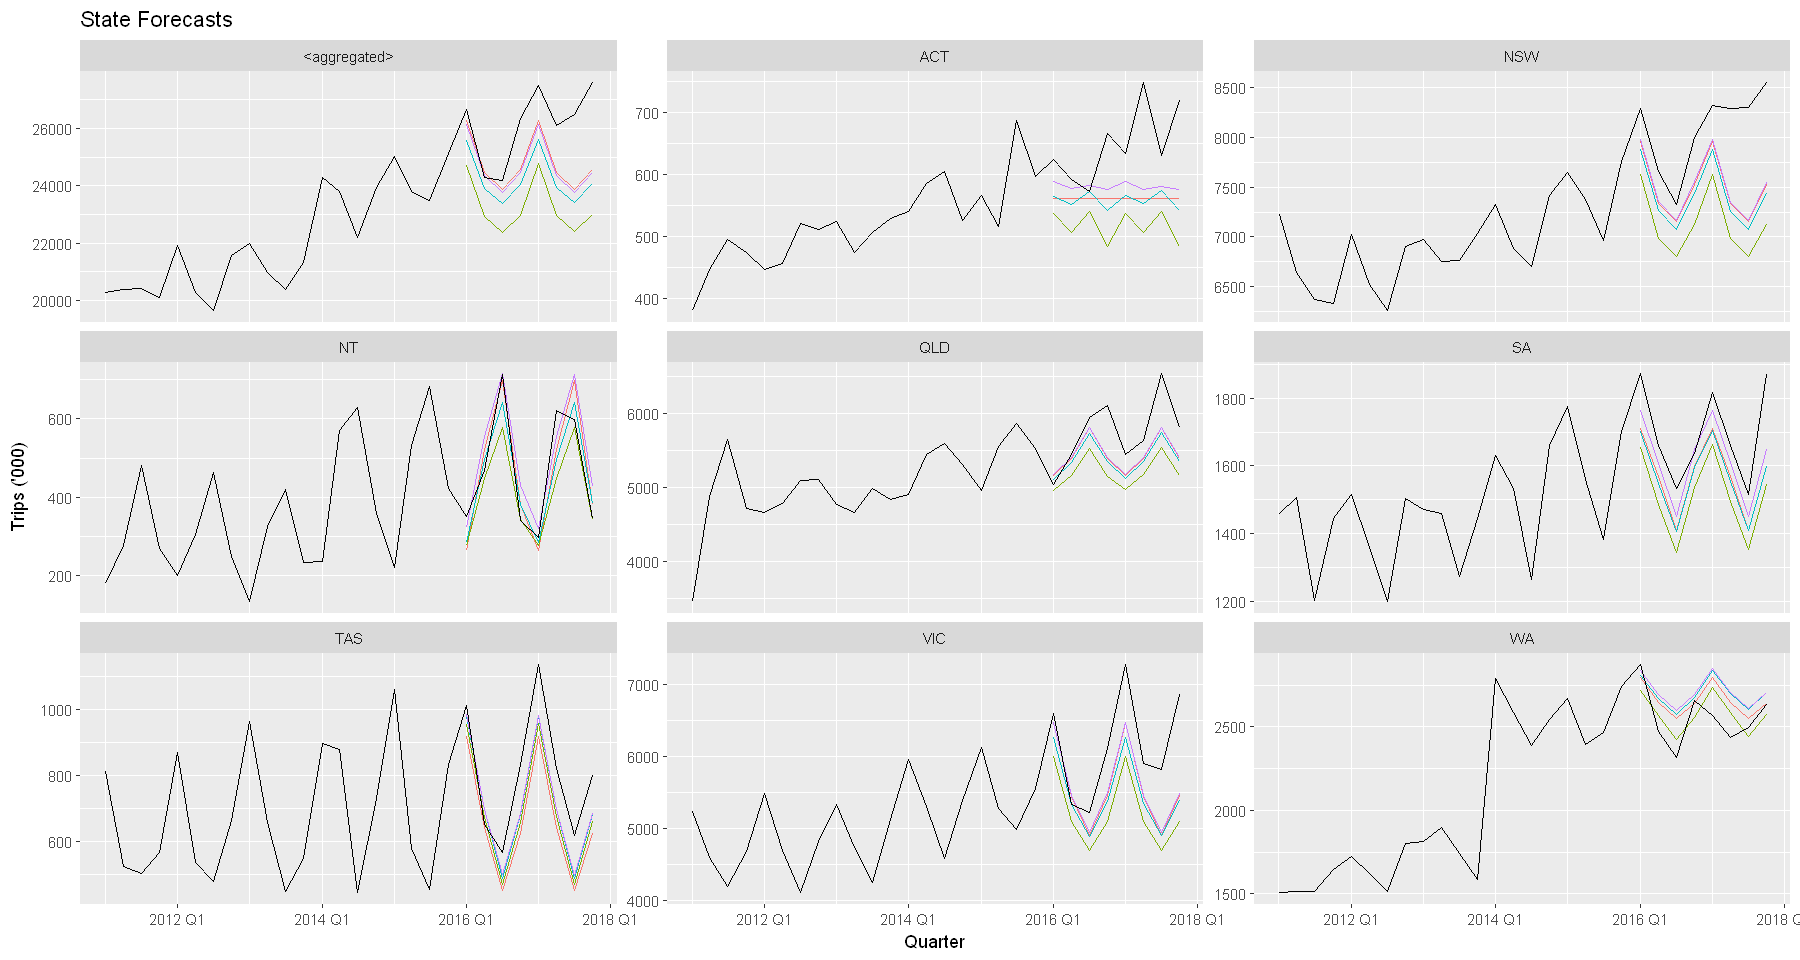

In [26]:
fc |>
  filter(is_aggregated(Region), is_aggregated(Purpose)) |>
  autoplot(
    tourism_full |> filter(year(Quarter) >= 2011),
    level = NULL
  ) +
  labs(y = "Trips ('000)", title='State Forecasts') +
  theme(legend.position = "none") +
  facet_wrap(vars(State), scales = "free_y")

ggsave(paste(plot_prefix, 'tourism_reconcile_state_forecasts.png', sep=''), height = 6, width = 7)

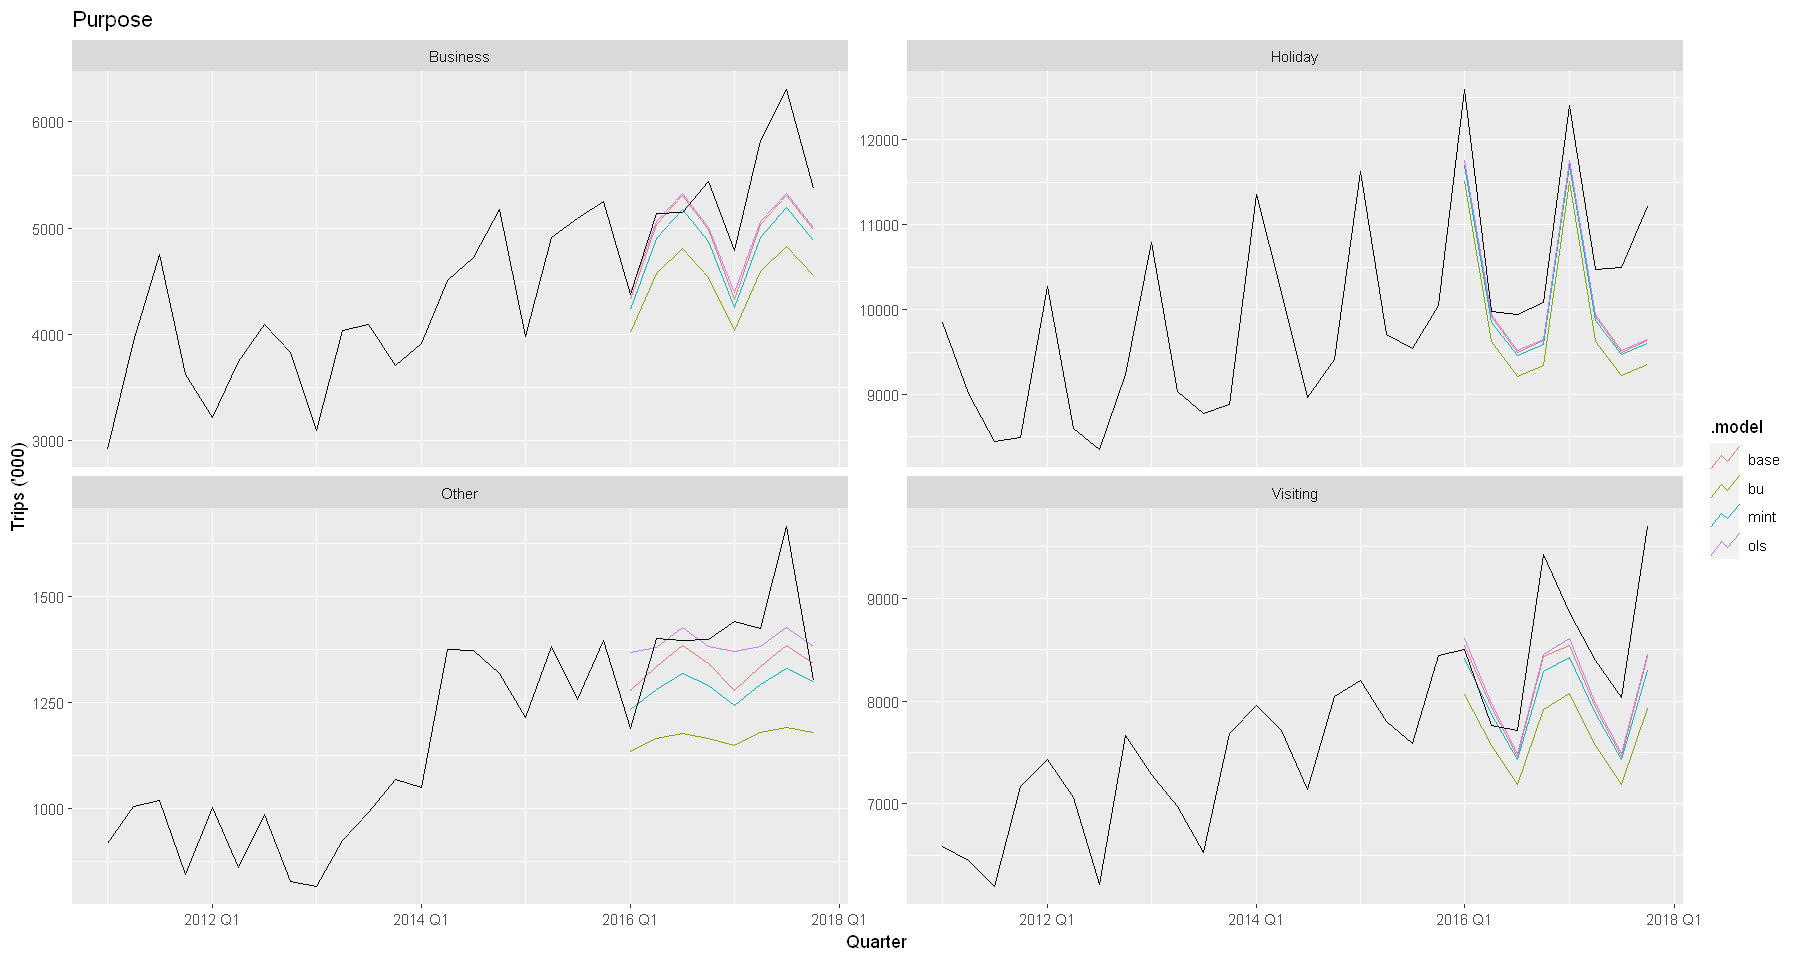

In [27]:
fc |>
  filter(is_aggregated(State), !is_aggregated(Purpose)) |>
  autoplot(
    tourism_full |> filter(year(Quarter) >= 2011),
    level = NULL
  ) +
  labs(y = "Trips ('000)", title='Purpose') +
  facet_wrap(vars(Purpose), scales = "free_y")

ggsave(paste(plot_prefix, 'tourism_reconcile_purpose_forecasts.png', sep=''), height = 6, width = 7)

In [28]:
# aggregate state, purpose
fc |>
  filter(is_aggregated(State), is_aggregated(Purpose)) |>
  accuracy(
    data = tourism_full,
    measures = list(rmse = RMSE, mase = MASE)
  ) |>
  group_by(.model) |>
  summarise(rmse = mean(rmse), mase = mean(mase))

.model,rmse,mase
<chr>,<dbl>,<dbl>
base,1720.724,1.532867
bu,3069.862,3.164072
mint,2157.588,2.086117
ols,1803.513,1.627071


In [29]:
# across all levels
fc |>
  accuracy(
    data = tourism_full,
    measures = list(rmse = RMSE, mase = MASE)
  ) |>
  group_by(.model) |>
  summarise(rmse = mean(rmse), mase = mean(mase))

.model,rmse,mase
<chr>,<dbl>,<dbl>
base,45.95798,1.035604
bu,55.25945,1.077737
mint,45.60982,0.983828
ols,43.19347,1.028813


### Reconciliation on Prisoner Data

In [30]:
prison_sg <- prison %>%
    aggregate_key(Gender * State, Count = sum(Count)/1e3)

prison_sg %>% head()

Quarter,Gender,State,Count
<qtr>,<chr*>,<chr*>,<dbl>
2005 Q1,<aggregated>,<aggregated>,24.296
2005 Q2,<aggregated>,<aggregated>,24.643
2005 Q3,<aggregated>,<aggregated>,24.511
2005 Q4,<aggregated>,<aggregated>,24.393
2006 Q1,<aggregated>,<aggregated>,24.524
2006 Q2,<aggregated>,<aggregated>,25.017


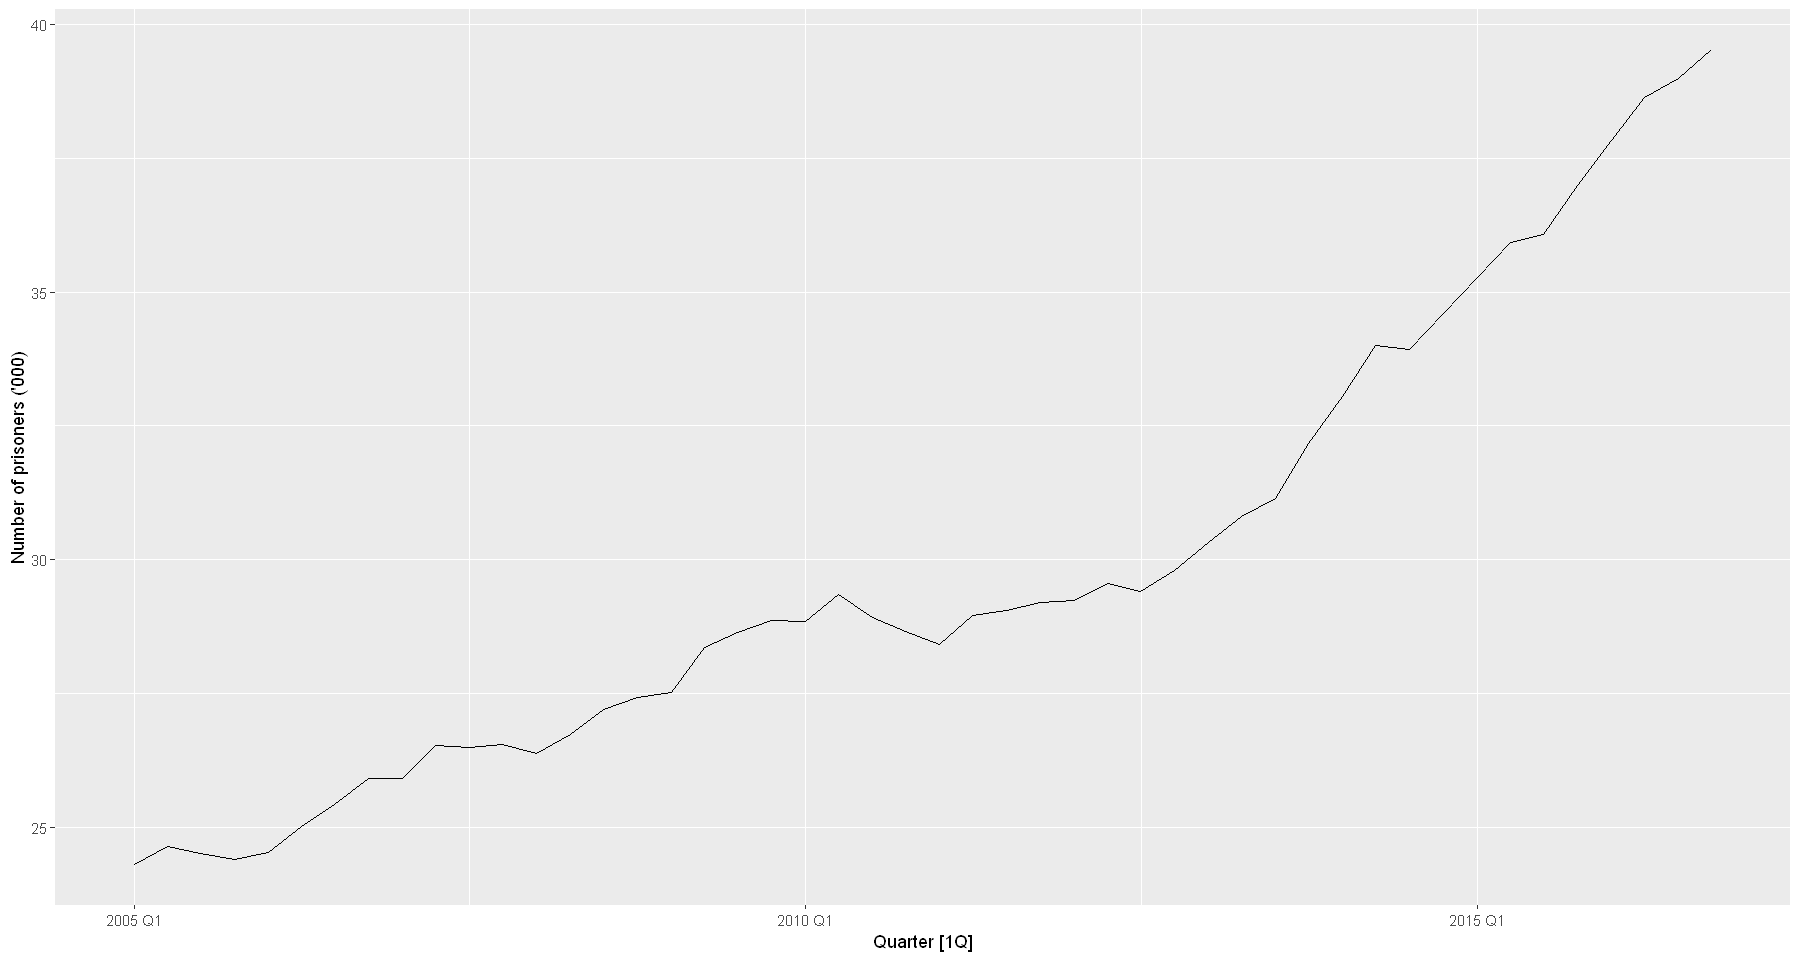

In [31]:
prison_sg |>
  filter(is_aggregated(Gender), is_aggregated(State)) |>
  autoplot(Count) +
  labs(y = "Number of prisoners ('000)")

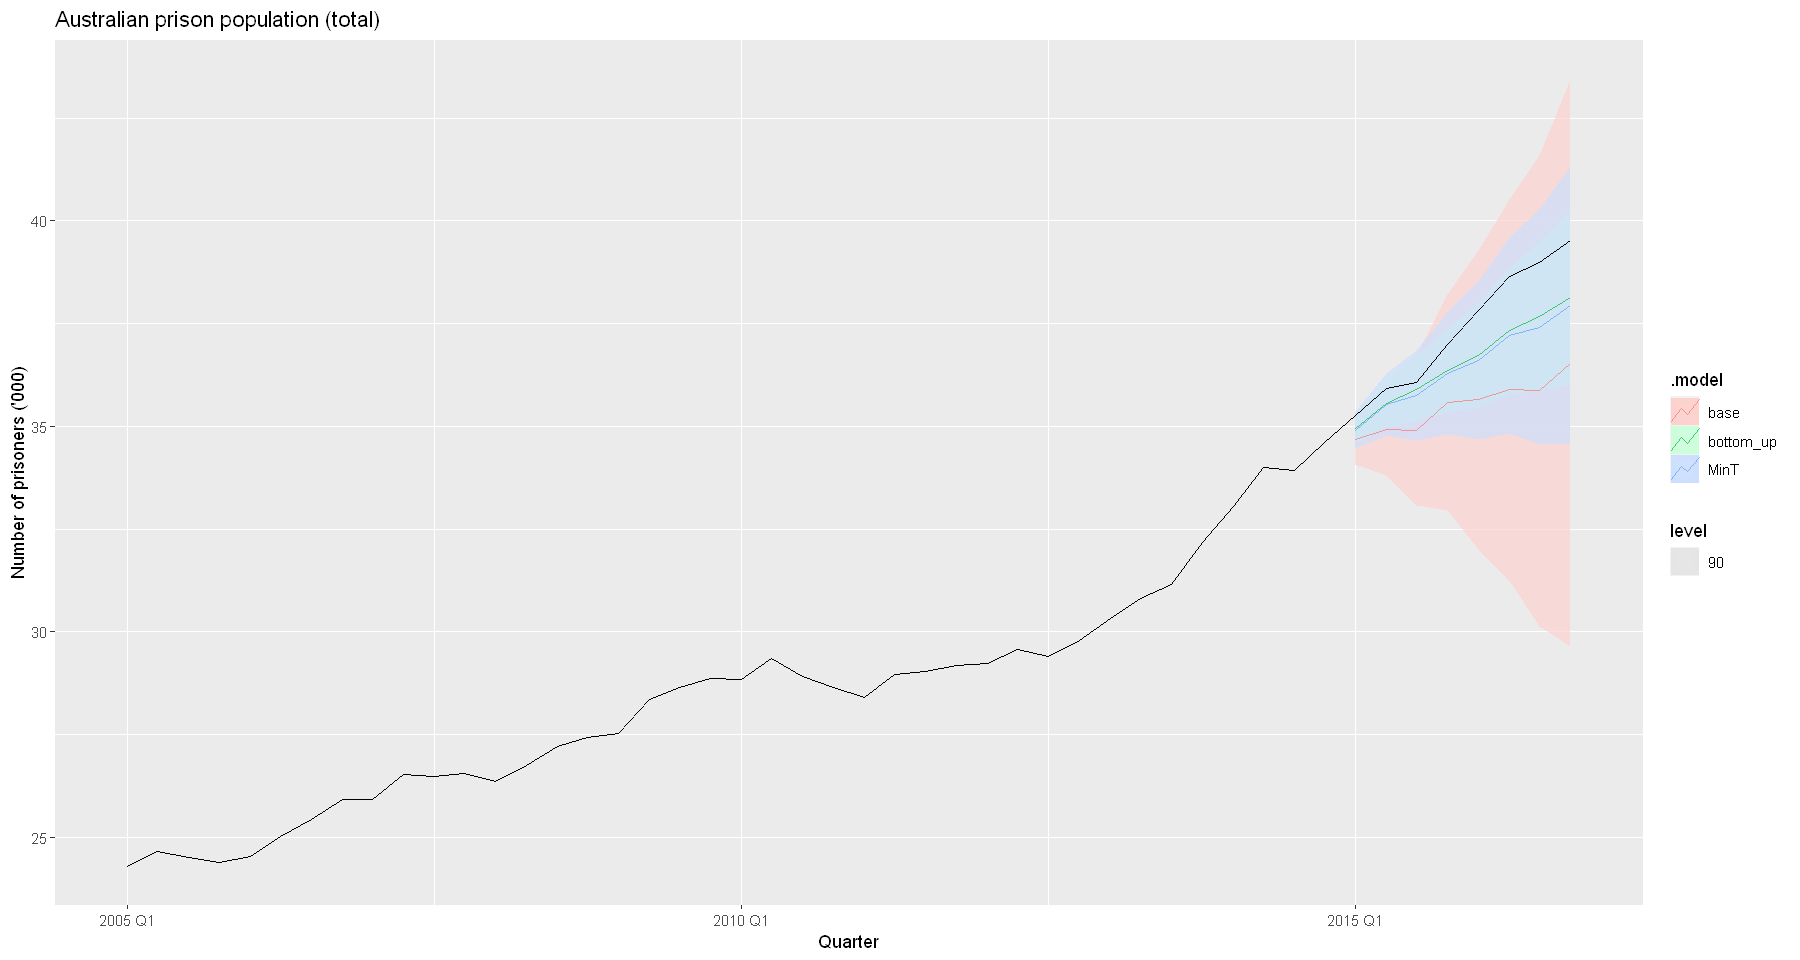

In [32]:
fit_sg <- prison_sg |>
  filter(year(Quarter) <= 2014) |>
  model(base = ETS(Count)) |>
  reconcile(
    bottom_up = bottom_up(base),
    MinT = min_trace(base, method = "mint_shrink")
  )
 
fc <- fit_sg |> forecast(h = 8)

fc |>
  filter(is_aggregated(State), is_aggregated(Gender)) |>
  autoplot(prison_sg, alpha = 0.7, level = 90) +
  labs(y = "Number of prisoners ('000)",
       title = "Australian prison population (total)")

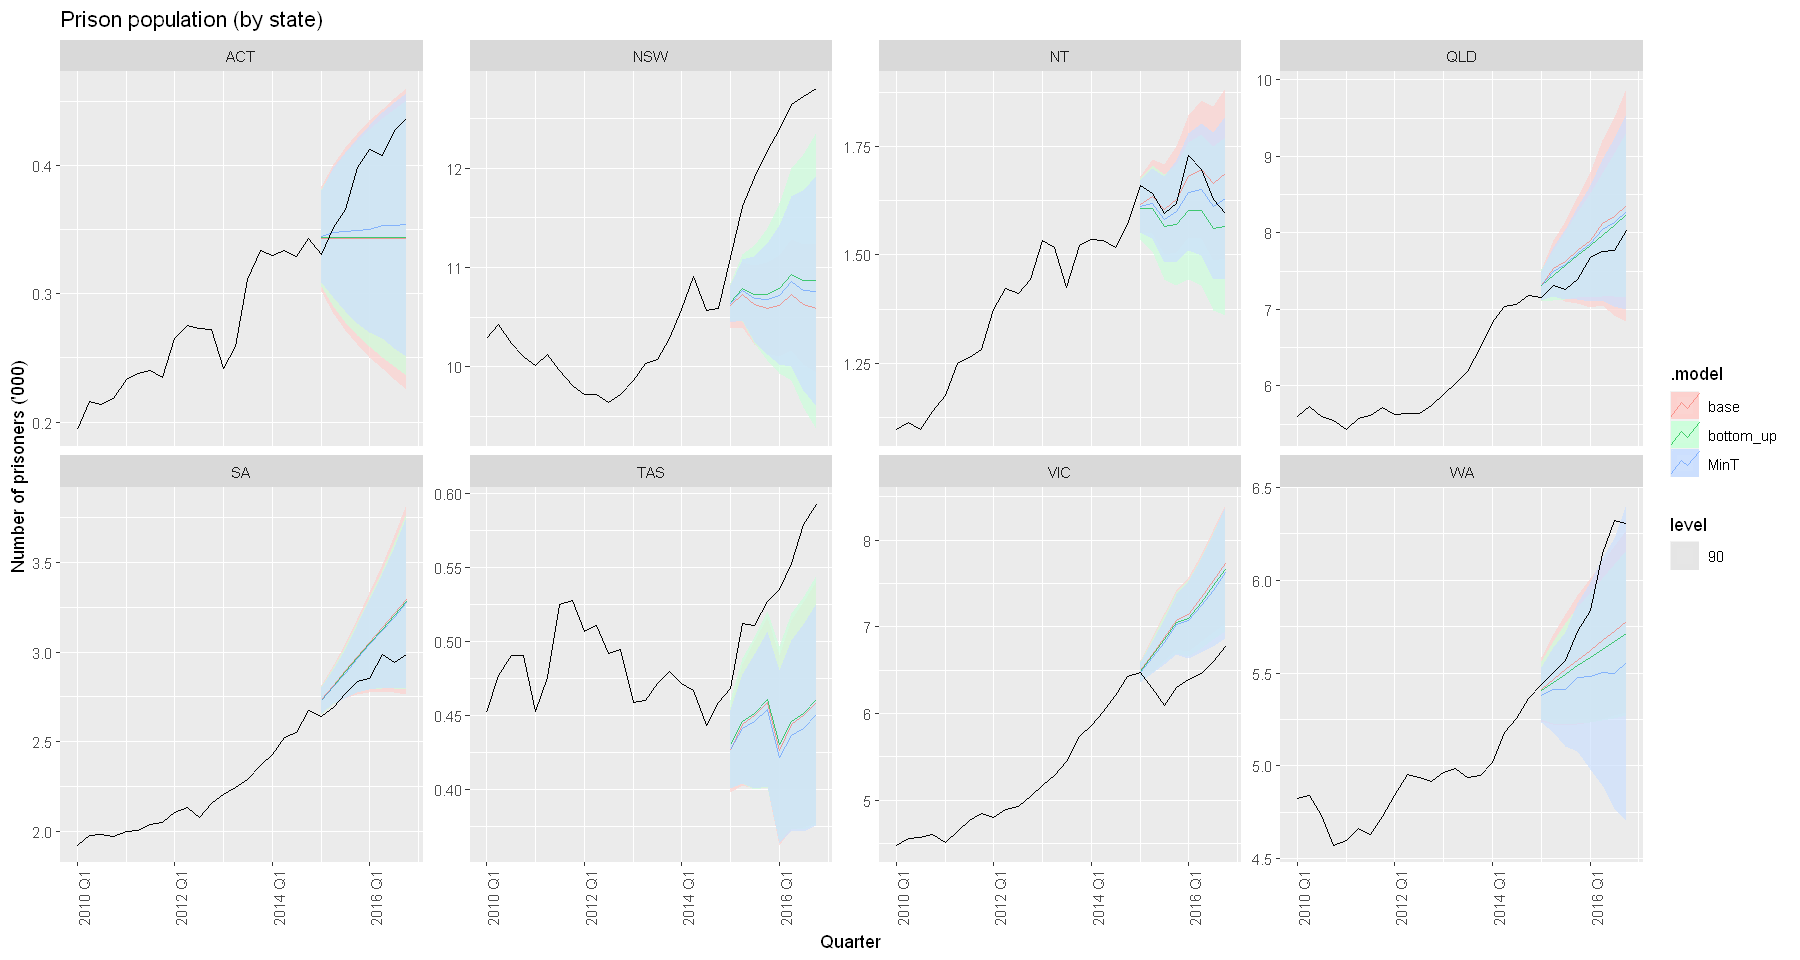

In [33]:
fc |>
  filter(
    !is_aggregated(State), is_aggregated(Gender)
  ) |>
  autoplot(
    prison_sg |> filter(year(Quarter) >= 2010),
    alpha = 0.7, level = 90
  ) +
  labs(title = "Prison population (by state)",
       y = "Number of prisoners ('000)") +
  facet_wrap(vars(State), scales = "free_y", ncol = 4) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

In [34]:
fc |>
  filter(is_aggregated(State), is_aggregated(Gender)) |>
  accuracy(data = prison_sg,
           measures = list(mase = MASE,
                           ss = skill_score(CRPS)
                           )
           ) |>
  group_by(.model) |>
  summarise(mase = mean(mase), sspc = mean(ss) * 100)

.model,mase,sspc
<chr>,<dbl>,<dbl>
MinT,0.8569168,78.09977
base,1.7198775,55.90979
bottom_up,0.7453458,80.00815
